In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from time import time
from collections import Counter, defaultdict
import nltk
from pprint import pprint
import copy

import seaborn as sns
from itertools import combinations


import pickle
from IPython.core.display import HTML

import pymongo
import pyLDAvis
%matplotlib inline

![](http://www.listchallenges.com/f/lists/d7aacdae-74bd-42ff-b397-b73905b5867b.jpg)

![](https://media.licdn.com/mpr/mpr/shrinknp_400_400/AAEAAQAAAAAAAASeAAAAJDA2YWEwZmFjLTg5MDgtNGE2OC04MTBhLTk3MzNiNGIxM2RkYQ.jpg)

# EDA - Presentation Version

This notebook is a cleaned up version of **EDA - Scrapy Version**. Here we refactor scrapy code in order to increase efficiency and readability in preperation for production, as well as provide ample explanations for methodoogy and results. 

### Import Data

In [11]:
def get_data_from_mongodb(db_name, coll_name):
    '''Returns documents from specifed database and collections in mongodb
       Will try to return docs in pandas dataframe
       If that fails, it will return a pointer to the data in mongo'''

    # pull scraped articles out of mongodb 
    client = pymongo.MongoClient()
    db = client.get_database(name = db_name)
    pointer_to_mongo_data = db[coll_name].find()
    
    try:
        # move articles to pandas
        df = pd.DataFrame(list(pointer_to_mongo_data))
        print ("Successfull - returned a df")
    
        return df
    except: 
        print ("Unsuccessfull - did not return a df")
        return pointer_to_mongo_data

In [12]:
db_name = "nyt2016"
coll_name = "articles"
df = get_data_from_mongodb(db_name, coll_name)

Successfull - returned a df


In [13]:
df.head(2)

,_id,abstract,blog,body,byline,document_type,headline,keywords,lead_paragraph,multimedia,...,print_page,pub_date,section_name,slideshow_credits,snippet,source,subsection_name,type_of_material,web_url,word_count
0,580ae247253f0a1d0316f71e,None,[],TOKYO — State-backed Japan Bank for Internati...,"{'original': 'By REUTERS', 'person': [], 'orga...",article,{'main': 'Japan to Lend to Sanctioned Russian ...,[],State-backed Japan Bank for International Coop...,[],...,None,2016-10-21T23:51:28Z,Business Day,None,State-backed Japan Bank for International Coop...,Reuters,None,News,http://www.nytimes.com/reuters/2016/10/21/busi...,None
1,580adf45253f0a1d0316f71d,None,[],"INTERNATIONAL\nBecause of an editing error, an...",[],article,"{'main': 'Corrections: October 22, 2016', 'pri...",[],"Corrections appearing in print on Saturday, Oc...",[],...,None,2016-10-21T23:38:36Z,Corrections,None,"Corrections appearing in print on Saturday, Oc...",The New York Times,None,News,http://www.nytimes.com/2016/10/22/pageoneplus/...,None


In [14]:
# create masks that identify "US" articles from the sections
US_section_mask = df.section_name == "U.S."
US_corpus_df = df[US_section_mask]
US_corpus = US_corpus_df.body.values

In [15]:
pprint(US_corpus[0])

('MADISONVILLE, Texas —  A school bus crashed into a car and overturned twice '
 'at an East Texas intersection, sending 16 of 18 of the children aboard to '
 'area hospitals.\n'
 'Sgt. Jimmy Morgan of the Texas Department of Public Safety says the bus '
 'driver and both occupants of the car also were transported to hospitals. He '
 'said none of the injuries appeared at the scene to be life-threatening.\n'
 'The crash happened about 4 p.m. Friday in Madisonville, about 90 miles north '
 'of Houston. Morgan says the car pulled from an Interstate 45 exit ramp onto '
 'Texas 75 in front of the bus. The bus slammed into the passenger side door '
 'before careening into a guardrail and overturning twice.\n'
 'Madisonville school district officials say the bus passengers ranged in age '
 'from 6 to 18 years old.\n'
 '___\n'
 'This story has been corrected to increase number of injuries to 19, '
 'including 16 children.')


### Topic Modeling

In [7]:
# write class that returns the 5 data objects we need for the data viz
class topic_model_distributions(object):
    '''This class fits Latent Dirichlet Allocation for topic modeling
       and returns topic-term dist, doc-topic dist, and other distributions
       needed for the pyLDAvis visulization.'''
    
    def __init__(self, term_freq_data, stopwords,n_topics):
        
        self.lda_model = None
        self.term_freq_data = term_freq_data
        self.stopwords = stopwords
        self.doc_topic_dist = None
        self.doc_lengths = None
        self.vocab = None
        self.doc_topic_probs = []
        self.topic_indices = []
        self.topic_word_count = dict()
        self.topic_term_dists_dict = {}
        self.topic_term_dists_matrix = None
        self.smoothing_prob = 0.001
        self.lda_model = LatentDirichletAllocation(n_topics=n_topics, 
                                           learning_method="online", 
                                           n_jobs=3,
                                           random_state=1234)        
    def fit_lda(self):
        self.lda_model.fit(self.term_freq_data)
        
    def set_doc_topic_dist(self):
        self.doc_topic_dist = self.lda_model.transform(self.term_freq_data)
        
        
        
    def set_topic_weight_and_index_(self):
        '''Sets probability that doc_i is a memeber of topic_j
           Sets topic index for each doc, i.e. doc_i is a member of topic_j'''

        for doc_probs in self.doc_topic_dist:
            
            # get topic index for each doc
            topic_index = np.argmax(doc_probs)
            self.topic_indices.append(topic_index)   
            
            # get probability that doc belongs to top topic
            doc_topic_prob = doc_probs[topic_index]
            self.doc_topic_probs.append(doc_topic_prob)


        
    def set_topic_word_count_(self):
        '''Sets total number of words that appear in each topic'''

        for doc_index, topic_index in enumerate(self.topic_indices):
            if topic_index not in self.topic_word_count.keys():
                self.topic_word_count[topic_index] = np.sum(self.term_freq_data[doc_index])
            else:
                self.topic_word_count[topic_index] += np.sum(self.term_freq_data[doc_index])
              
    def set_topic_term_matrix(self):
        '''Sets the topic-term distribution matrix'''
        
        self.set_topic_weight_and_index_()
        self.set_topic_word_count_()
        
        
        # iterate through topics ids for all docs in corpus
        for doc_index, topic_index in enumerate(self.topic_indices):
            # term frequency for doc i of topic j 
            doc_i_term_freq = self.term_freq_data[doc_index].toarray()[0]
            # normalized probabilities of words in doc i of topicj 
            # i.e. these words now have probs that correspond to their prob of appear in topic j
            doc_i_term_freq_normalized = doc_i_term_freq/self.topic_word_count[topic_index] 

            if topic_index not in self.topic_term_dists_dict.keys():
                self.topic_term_dists_dict[topic_index] = doc_i_term_freq_normalized
            else:
                self.topic_term_dists_dict[topic_index] += doc_i_term_freq_normalized

        self.topic_term_dists_matrix = np.vstack(self.topic_term_dists_dict.values())        

        
    def get_doc_topic_dist(self):
        '''Returns the doc topic probability distributions'''
        return  self.doc_topic_dist
    
    def get_topic_term_matrix(self):
        """Returns the topic-term probability distribution matrix"""
        return self.topic_term_dists_matrix
    
    def get_doc_lengths(self):
        '''Returns the number of words in each document'''
        # doc_lengths  -  the number of words in each document - shape `n_docs`
        return [doc.sum() for doc in self.term_freq_data]
        


In [8]:
# get term freq
count_vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
termFreq = count_vectorizer.fit_transform(US_corpus)

In [9]:
tmdist_object = topic_model_distributions(termFreq, ENGLISH_STOP_WORDS, n_topics=5)

start = time()
tmdist_object.fit_lda()
tmdist_object.set_doc_topic_dist()
tmdist_object.set_topic_term_matrix()
end = time()
print ( "{:.4} minutes ".format((end - start )/60 ) )

1.331 minutes 


In [10]:
start = time()
doc_topic_dist = tmdist_object.get_doc_topic_dist()
topic_term_dist = tmdist_object.get_topic_term_matrix()
doc_lengths = tmdist_object.get_doc_lengths()
topic_ids = tmdist_object.topic_indices
end = time()
print ( "{:.4} minutes ".format((end - start )/60 ) )

0.02274 minutes 


In [11]:
# vocab             -  List of all the words in the corpus  -  shape `n_terms`
vocab = count_vectorizer.get_feature_names()

# term_frequency    -  The count of each particular term over the entire corpus. 
#                      The ordering of these counts should correspond with `vocab` and `topic_term_dists`.
term_frequency = termFreq.toarray().sum(axis = 0)

In [12]:
topic_terms_probs = tmdist_object.lda_model.components_

In [13]:
pyLDAvis.enable_notebook()

prepared_data = \
pyLDAvis.prepare(topic_term_dists = topic_term_dist,
                 doc_topic_dists=doc_topic_dist,
                 doc_lengths=doc_lengths, 
                 vocab=vocab,
                 term_frequency=term_frequency)

In [14]:
pyLDAvis.display(prepared_data)

In [5]:
topic_labels = ["political scandals", "infrastructure ", "justice system", 'presidential election', "environmental issues"]

![](./topic_chart.png)


### Entity Recognition

In [111]:
class named_entity_extraction(object):
    
    def __init__(self, topic_ids,corpus):
        
        self.topic_ids = topic_ids
        self.corpus = corpus
        self.doc_ids = list(range(len(corpus)))
        self.unique_entity_type = 'persons'
        
        # each entity from each entity type is stored here
        self.entity_results_dict = dict()
        # unique entities from self.unique_entity_type are stored here
        self.unique_entities_dict = dict()
        
        # { topic_id : { name_i: count_i  }  }
        self.persons_dict = dict()
        self.persons_topics_dict  = None
        
    def get_entities(self):
        '''This function identities, tags, and extracts named entites from each doc 
           in the corpus. The extracted entities are stored in dicts. 
           
           self.entity_results_dict: stores all named entites from each doc
           self.unique_entities_dict: sotres unique person named entites from each doc
           '''

        for topic_id, doc_id, doc in zip(self.topic_ids, self.doc_ids, self.corpus):
            
            # tokenize doc 
            self.tokenized = nltk.word_tokenize(doc)
            # identify part-of-speech for each token
            self.tagged = nltk.pos_tag(self.tokenized)
            # identify the entities 
            self.namedEnt_doc_i = nltk.ne_chunk(self.tagged, binary=False)

            for entity in self.namedEnt_doc_i:
                # check if token is entities
                if isinstance(entity, nltk.tree.Tree):
                    self.etext = " ".join([word for word, tag in entity.leaves()])
                    self.label = entity.label()
                else:
                    continue

                if self.label == 'PERSON':
                    self.key = 'persons'
                elif self.label == 'ORGANIZATION':
                    self.key = 'organizations'
                elif self.label == 'LOCATION':
                    self.key = 'locations'
                elif self.label == 'GPE':
                    self.key = 'other'
                else:
                    self.key = None

                # if topic is new to results dict, then create a new dict for that topic
                if topic_id not in self.entity_results_dict.keys():
                    self.entity_results_dict[topic_id] = defaultdict(list)
                    
                # if topic is new to results dict, then create a new dict for that topic
                if topic_id not in self.unique_entities_dict.keys():
                    self.unique_entities_dict[topic_id] = defaultdict(set)


                # store all types of named entitis
                # topic_i : {entity_type: entity}
                self.entity_results_dict[topic_id][self.key].append(self.etext.lower()) 

                # store only person entities
                if self.key == self.unique_entity_type:
                    # topic_i : {doc_j : (set of entities that appear in doc_j) } 
                    self.unique_entities_dict[topic_id][doc_id].add(self.etext.lower())
        
        
    def get_name_entity_count(self, entity_type = 'persons'):
        '''Returns the count of occurances of each name entity in each topic'''


        for topic_id, entity_dict in self.entity_results_dict.items():
            self.persons_dict[topic_id] = Counter(self.entity_results_dict[topic_id][entity_type])

        return self.persons_dict
 
    def get_entity_topic_count(self):
        '''Returns a dict where keys are topic ids and values are sum 
           of all entities that appear in the topic'''

        entity_count_dic = {}
        topic_ids = self.entity_results_dict.keys()

        self.entity_results_dict_flatten = self.flatten_results(self.entity_results_dict)

        for topic_id in topic_ids:
            entity_count_dic[topic_id] = len(self.entity_results_dict_flatten[topic_id])

        return entity_count_dic
    
    
    
    # clean named_entity_results
    def flatten_results(self, entity_dict_data):
        '''Returns entity dict with flatten values. 

           The extract entities in the get_entities function returned nested lists
           in the dict values. Here we are correcting the format.'''


        # make deep copy of dict
        # so original dict is not over written
        self.entity_dict_flat = copy.deepcopy(entity_dict_data)

        topics = self.entity_dict_flat.keys()
        for topic in topics:
            flattend_values = np.array(list(entity_dict_data[topic].values())).flatten()[0]

            self.entity_dict_flat[topic] = flattend_values

        return self.entity_dict_flat
    
    
    def invert_nested_dict(data):
        '''Returns the inverstion of a nested dictionary. 
        
           Helper function for self.get_entity_topic_occurance'''

        flipped = defaultdict(dict)
        for key, val in data.items():
            for subkey, subval in val.items():
                flipped[subkey][key] = subval
                
        return flipped
    
    
    def get_entity_topic_occurance(self):
        '''Returns a nested dictionary with entity as key and {topic:occurance} as the dict value'''
        self.persons_topics_dict  = self.get_name_entity_count()
        
        return invert_nested_dict(self.persons_topics_dict)
    

### How entity extraction works

In [84]:
example_doc= 'Alexander studied data science at Galvanize, in San Francisco.'
tokenized = nltk.word_tokenize(example_doc)
tagged = nltk.pos_tag(tokenized)
namedEnt_doc_i = nltk.ne_chunk(tagged, binary=False)

['Alexander', 'studied', 'data', 'science', 'at', 'Galvanize', ',', 'in', 'San', 'Francisco', '.'] 

[('Alexander', 'NNP'),
 ('studied', 'VBD'),
 ('data', 'NNS'),
 ('science', 'NN'),
 ('at', 'IN'),
 ('Galvanize', 'NNP'),
 (',', ','),
 ('in', 'IN'),
 ('San', 'NNP'),
 ('Francisco', 'NNP'),
 ('.', '.')]


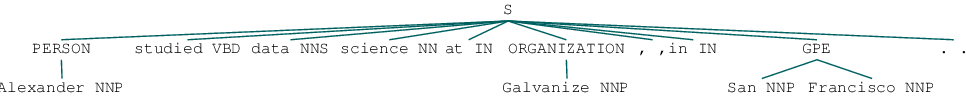

In [166]:
print (example_doc)
print (tokenized, '\n') 
pprint (tagged)

namedEnt_doc_i

In [137]:
extraction_object = named_entity_extraction(topic_ids, US_corpus)

In [138]:
start = time()
extraction_object.get_entities()
end = time()
print (  "Total run time: {:.4} minute ".format((end - start)/60)   )
print ("Each document takes about {:.4} seconds to find all entities".format((20)/US_corpus.shape[0]) )

Total run time: 17.79 minute 
Each document takes about 0.003312 seconds to find all entities


In [139]:
persons_topics_dict = extraction_object.get_name_entity_count(entity_type = 'persons')
entity_count_dic = extraction_object.get_entity_topic_count()
entity_topic_occurance = extraction_object.get_entity_topic_occurance()
topic_ids = extraction_object.topic_ids
unique_entities_dict = extraction_object.unique_entities_dict

#### Save entity extraction results to file

In [7]:
# with open('persons_topics_dict.pickle', 'wb') as handle:
#     pickle.dump(persons_topics_dict, handle)
    
# with open('entity_count_dic.pickle', 'wb') as handle:
#     pickle.dump(entity_count_dic, handle)
    
# with open('entity_topic_occurance.pickle', 'wb') as handle:
#     pickle.dump(entity_topic_occurance, handle)
    
# with open('topic_ids.pickle', 'wb') as handle:
#     pickle.dump(topic_ids, handle)
    
# with open('unique_entities_dict.pickle', 'wb') as handle:
#     pickle.dump(unique_entities_dict, handle)

# with open('topic_labels.pickle', 'wb') as handle:
#     pickle.dump(topic_labels, handle)

#### Load entity results data

In [2]:
with open('persons_topics_dict.pickle', 'rb') as handle:
    persons_topics_dict = pickle.load(handle)
    
with open('entity_count_dic.pickle', 'rb') as handle:
    entity_count_dic = pickle.load( handle)
    
with open('entity_topic_occurance.pickle', 'rb') as handle:
    entity_topic_occurance = pickle.load(handle)
    
with open('topic_ids.pickle', 'rb') as handle:
    topic_ids = pickle.load(handle)
    
with open('unique_entities_dict.pickle', 'rb') as handle:
    unique_entities_dict = pickle.load(handle)
    
with open('topic_labels.pickle', 'rb') as handle:
    topic_labels = pickle.load(handle)    

In [3]:
topic_labels

['political scandals',
 'infrastructure ',
 'justice system',
 'presidential election',
 'environmental issues']

In [4]:
def replace_topic_names_in_dict_keys(dic, topic_label):
    for topic_label, num_label in zip(topic_labels, dic.keys()):
        dic[topic_label] = dic.pop(num_label)

    return dic

In [5]:
# run only once
unique_entities_dict =  replace_topic_names_in_dict_keys(unique_entities_dict, topic_labels)

In [6]:
unique_entities_dict.keys()

dict_keys(['justice system', 'environmental issues', 'infrastructure ', 'presidential election', 'political scandals'])

## Named Entity Searche Engine 

In [113]:
class entity_topic_occurances(object):
    
    def __init__(self, query_list, entity_topic_occurance, unique_entities_dict, topic_labels):
          
        # user's set of person entites
        self.query_list = query_list
        # dictionary of unique appearances of entites in each doc of each topic passed into dataframe
        # {entity : {topic : num_occurances } }
        self.entity_topic_occurance_df = pd.DataFrame(entity_topic_occurance).T.fillna(0)
        # topic labels named during topic modeling
        self.topic_labels = topic_labels
        # co-occurance matrix between user passed entities and topics
        self.entity_topic_co_occurance_df = self.entity_topic_occurance_df.T[self.query_list].T
        # assign topic labels as column names in dataframe
        self.entity_topic_co_occurance_df.columns = self.topic_labels
        # {topic : {doc_id : set_of_entities } }
        self.unique_entities_dict = unique_entities_dict
    
    def get_entity_topic_co_occurance(self):
        '''Returns the entity topic co-occurance dataframe'''
        return self.entity_topic_co_occurance_df
        
        
        
        
    def get_docs_with_co_occurances(self, subset_topic_labels=None):
        '''Returns list of doc ids for co-occurances of entites'''

        self.co_occurances_doc_ids = []

        if subset_topic_labels == None:
            self.topic_lables_to_search = self.topic_labels
        else:
            self.topic_lables_to_search = subset_topic_labels


        for topic_label in self.topic_lables_to_search:

            for doc_id, set_of_entities in self.unique_entities_dict[topic_label].items():

                if set_of_entities.issuperset(self.query_set ):
                    self.co_occurances_doc_ids.append(doc_id)

        return self.co_occurances_doc_ids
    
    
    def get_num_co_occurances(self,  query_set, n_entities = 2, subset_topic_labels=None):

        '''Returns nested dict of entity co-occurances in docs'''

        self.co_entity_dict = defaultdict(dict)
        

        self.query_set = query_set

        # create a set of n Choose k pairs for entities
        # create every possible pair between the entites 
        self.entity_pair_combinations = combinations( self.query_set , n_entities)

        for co_entities in self.entity_pair_combinations:

            self.entity_pairs = set(co_entities)

            # for each unique combination of entity pairs, get all doc ids in which they jointly appear
            self.co_entity_doc_ids = self.get_docs_with_co_occurances(subset_topic_labels)


            # populate nested dict for use in a co-occurance matrix 
            self.co_entity_dict[co_entities[0]][co_entities[1]] = len(self.co_entity_doc_ids)
            self.co_entity_dict[co_entities[1]][co_entities[0]] = len(self.co_entity_doc_ids)

        return self.co_entity_dict

In [114]:
# user creates a query list
query_list = ['elon musk', 'bill clinton', 'paul ryan', 'bill maher', 'bernie sanders', 'edward snowden', 'clinton', 'trump']

In [115]:
# instantiate entity_topic_occurances class
occurance_object = entity_topic_occurances(query_list, # user's named entites 
                                           entity_topic_occurance, # entity-topic-doc occurance
                                           unique_entities_dict,  # topic-doc-entity unique occurances
                                           topic_labels) # hand labled topic names

### Co-Occurance between Entities and Topics

In [116]:
entity_topic_co_occurance_df = occurance_object.entity_topic_co_occurance_df
entity_topic_co_occurance_df

,political scandals,infrastructure,justice system,presidential election,environmental issues
elon musk,0.0,0.0,0.0,1.0,2.0
bill clinton,7.0,141.0,8.0,183.0,11.0
paul ryan,0.0,80.0,5.0,9.0,6.0
bill maher,0.0,3.0,0.0,0.0,0.0
bernie sanders,0.0,62.0,4.0,65.0,14.0
edward snowden,0.0,0.0,0.0,8.0,0.0
clinton,13.0,3669.0,28.0,4567.0,313.0
trump,49.0,4486.0,10.0,1991.0,248.0


In [117]:
def plot_occurances(df, mask=None):
    '''Plot occurance matrix has heat map'''
    
    if mask:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True     
    
    # ploting entity occurance in topics
    plt.figure(figsize = (15,6))
    sns.heatmap(df, annot=True, mask=mask, fmt="g", linewidths=0.5,cmap='Blues');

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


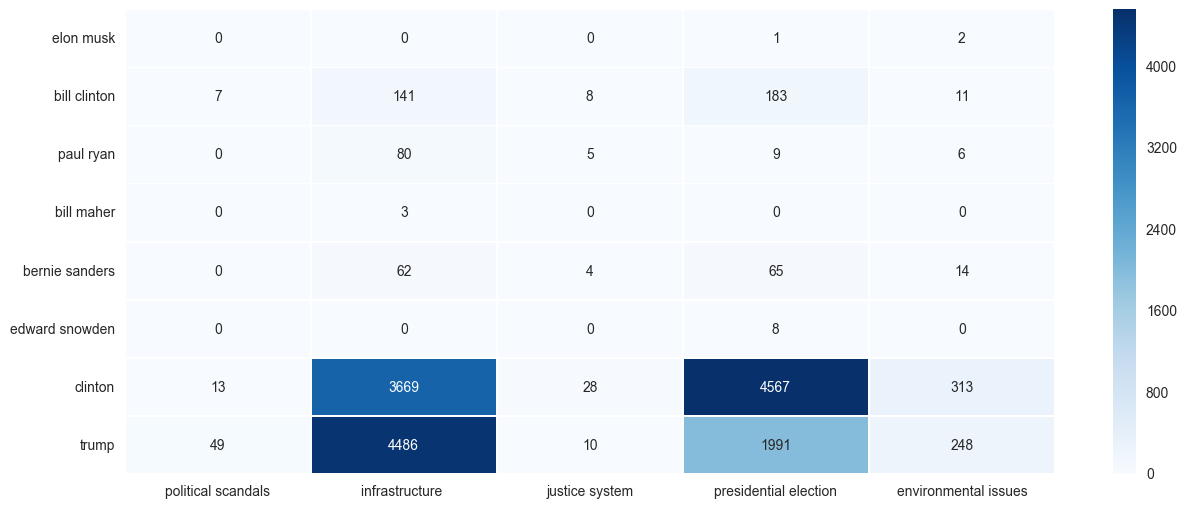

In [118]:
plot_occurances(entity_topic_co_occurance_df)

### Co-Occurances between Entities in Documents

#### Co-Occurance between Entities in Documents for Corpus

In [119]:
query_set = set(query_list)

In [147]:
# debug get_num_co_occurances output
for i in combinations(set(( 'trump', "clinton", 'paul ryan')), 2):
    print (i)

('paul ryan', 'trump')
('paul ryan', 'clinton')
('trump', 'clinton')


In [121]:
co_entity_dict = occurance_object.get_num_co_occurances(query_set=query_set)

In [132]:
# users specifices which co occurances they are interested in
query_co_occurances = set(( 'trump', "clinton", 'paul ryan'))

In [133]:
co_occur_in_docs = occurance_object.get_num_co_occurances(query_co_occurances)
co_occur_in_docs

defaultdict(dict,
            {'clinton': {'paul ryan': 51, 'trump': 51},
             'paul ryan': {'clinton': 51, 'trump': 51},
             'trump': {'clinton': 51, 'paul ryan': 51}})

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


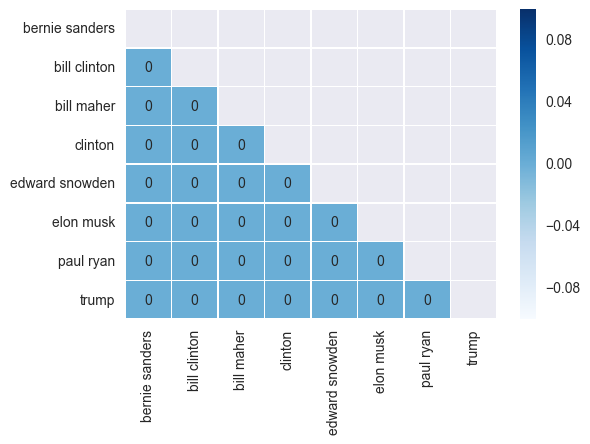

In [124]:
plot_occurances()

In [125]:
 co_entity_dict, co_entity_doc_ids_list = get_num_co_occurances(user_co_occurance_entities_set, 
                                                                unique_entities_dict, 
                                                                co_occurances_doc_ids,
                                                               1)

NameError: name 'get_num_co_occurances' is not defined

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


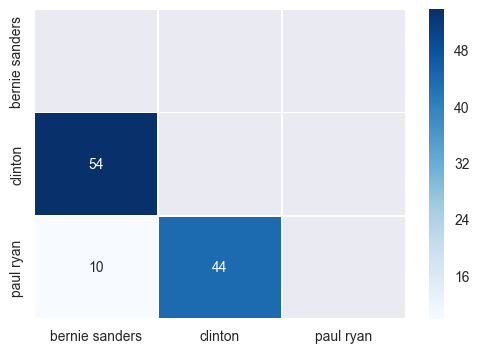

In [105]:
mask = np.zeros_like( pd.DataFrame(co_entity_dict).fillna(0), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# co-occurances of entities in docs within the corpus 
sns.heatmap(pd.DataFrame(co_entity_dict), mask=mask, annot=True, fmt="g", linewidths=0.5,cmap='Blues')

#### Ad-Hoc Queries

Find out how many documents contain all of the user's entites. 

In [71]:
 co_occurances_doc_ids = get_docs_with_co_occurances(user_co_occurance_entities_set, unique_entities_dict)

The user can now pull all the relavent documents from the corpus. 

In [72]:
# bernie and paul and clinton co-occur in all of these docs within the corpus
print(co_occurances_doc_ids[0:5]), len(co_occurances_doc_ids)

[146, 4887, 4979, 792, 4958]


(None, 9)